In [1]:
# Most Basic
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import math
from os import path
import sys
from datetime import datetime
from scipy.stats import norm
import scipy.stats as ss
import copy
import warnings
warnings.simplefilter('error')
import datetime

# Filter Specific Functionalities
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import MerweScaledSigmaPoints

# Gradient Based
import autograd.numpy as a_np
import autograd.scipy.stats as a_ss
from autograd import grad, multigrad_dict, elementwise_grad, jacobian

# Self Defined functions5
from DataMaker_New import dataCleaner_new
from ESN import EchoState
from Loss import loss

In [118]:
columns = ["date","exdate","strike_price","best_bid","best_offer","volume","impl_volatility"]
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2019, 12, 31)
train_valid_split = 0.936
valid_test_split = 0.94
u_dim = 10
topK = 5
cleaner = dataCleaner_new(columns, u_dim, topK, start, end, train_valid_split, valid_test_split)
return_dict, price_dict = cleaner.make_return_price()
risk_dict = cleaner.make_risk()
train_data, valid_data, test_data = cleaner.make_final_data(price_dict, return_dict, risk_dict)
num_train_day, num_train_obs = cleaner.get_train_num()
num_valid_day, num_valid_obs = cleaner.get_valid_num()
num_test_day, num_test_obs = cleaner.get_test_num()

# train_data[np.datetime64('2019-01-02T00:00:00.000000000')]

Attached 351 days of train data
Attached 1755 train option observations
Attached 1 days of validation data
Attached 5 validation option observations
Attached 23 days of test data
Attached 115 test option observations


In [4]:
# Define transition Dynamics
# Positional requirement, no real effect, will be replaced by ESN and BS defined further down
def fx(x, dt):
    return x*dt
def hx(x):
    return x

def sigmoid(x):
    return np.divide(1, 1+np.exp(-x))


def ESNf(theta_now, dt, **fx_args):
    """
    :params theta_now theta_t
    
    **fx_args
    :params G reservoir transition matrix
    :params G_in input translation matrix
    :params b reservoir bias vector
    :params u_quad_now u_t^2
    """
    G = fx_args["G"]
    G_in = fx_args["G_in"]
    b = fx_args["b"]
    u_quad_now = fx_args["u_quad_now"]
    theta_next = sigmoid(np.matmul(G, theta_now) + np.matmul(G_in, u_quad_now) + b)
    return theta_next
    

def BSf(theta_t, **hx_args):
    """
    :params theta_t current state vector
    
    **hx_args
    :params p_t current asset price
    :params r_t current asset price
    :params K_t strike price, 1d vector
    :params T_t maturity time, 1d vector
    """
    p_t = hx_args["p_t"]
    r_t = hx_args["r_t"]
    K_t = hx_args["K_t"]
    T_t = hx_args["T_t"]
    
    volatility_std = np.average(theta_t)
    volatility_var = np.power(volatility_std, 2)
    
    dividor = np.sqrt(volatility_var * T_t)
    d_pls = (np.log(p_t/K_t) + np.multiply(r_t+volatility_var/2, T_t)) / dividor
    d_mns = (np.log(p_t/K_t) + np.multiply(r_t-volatility_var/2, T_t)) / dividor
    y_t = np.multiply(p_t, norm.cdf(d_pls)) - np.multiply(np.multiply(K_t, np.exp(-r_t*T_t)), norm.cdf(d_mns))
    return y_t

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)


# 睡觉专区

In [119]:
np.random.seed(1234)
gradient = grad(loss)


forward_k = 20

error_for_all_theta_dim = []
best_itr_for_all_theta_dim = []
best_train_itr_for_all_theta_dim = []
params_for_all_theta_dim = []
ms_s_for_all_theta_dim = []
Cs_s_for_all_theta_dim = []

for theta_dim in np.arange(2, 11, 1):

    m_t_1 = [np.array([0]), np.array([0]), np.array([0])]
    v_t_1 = [np.array([0]), np.array([0]), np.array([0])]
    beta_1 = 0.9
    beta_2 = 0.999
    epsillon = 1e-8
    
    print("theta_dim = {}".format(theta_dim))
    alpha = 5
    connectivity = 0.4
    spectral_radius = 0.98
    bday_p_year = 252
    bias = -7

    v_scale = 100.0
    target_var = 1e-6
    chi_mu = math.sqrt(2)* math.gamma((theta_dim+1)/2) / math.gamma(theta_dim/2)
    W_scale = target_var+chi_mu

    # initialize ESN dynamics
    ESN = EchoState(theta_dim, u_dim, connectivity, spectral_radius, bias)
    W = np.eye(theta_dim)*W_scale
    v = v_scale

    last_avg_error = 100
    best_itr = 0
    best_train_error = 100
    best_train_itr = 0
    
    #%%%%%% Error trajectories
    
    test_error_traj = []
    params_traj = []
    ms_s_traj = []
    Cs_s_traj = []
    
    for em_itr in range(200):
        dt=1
        points = MerweScaledSigmaPoints(theta_dim, alpha=.001, beta=2., kappa=0)
        ukf = UnscentedKalmanFilter(dim_x=ESN.theta_dim, dim_z=topK, dt=1, fx=fx, hx=hx, points=points)
        ukf.x = np.ones(ESN.theta_dim)* 0.006 # initial state
        ukf.P *= 0.01 # initial uncertainty
        ukf.R = np.diag([v]*topK) # 1 standard
        ukf.Q = W

        ms = [ukf.x.copy()]
        Cs = [ukf.P.copy()]
        u_quad_s = []
        ps = []
        rs = []
        ys = []
        Ks = []
        us = []
        Ts = []

        all_days = sorted(list(train_data.keys()))
        for day in all_days:
            # get observable data
            ## Stock Wise and market wise data
            r_t = train_data[day][1] / bday_p_year
            u_t = train_data[day][2].reshape([-1])
            p_t = train_data[day][3]

            ## Option wise data
            y_t = train_data[day][0]["spotclose"].values
            K_t = train_data[day][0]["strike_price"].values
            today = [d.date() for d in train_data[day][0]["date"]]
            expireday = [d.date() for d in train_data[day][0]["exdate"]]
            T_t = np.busday_count(today, expireday)


            ukf.predict(fx = ESNf, G=ESN.G, G_in=ESN.G_in, b= ESN.b, u_quad_now=np.power(u_t,2))
            ukf.update(y_t, hx=BSf, p_t=p_t, r_t=r_t, K_t=K_t, T_t=T_t)
            ms.append(ukf.x_post.copy())
            Cs.append(ukf.P_post.copy())
            u_quad_s.append(np.power(u_t,2))
            us.append(u_t)
            ps.append(p_t)
            rs.append(r_t)
            ys.append(y_t)
            Ks.append(K_t)
            Ts.append(T_t)

        ms = np.array(ms)
        Cs = np.array(Cs)
        ms_s, Cs_s, _, cvs_s = ukf.rts_smoother(ms, Cs, fx=ESNf, G=ESN.G, G_in=ESN.G_in, b=ESN.b, u_s=us)


        params = [ESN.G, ESN.G_in, ESN.b, ukf.Q, v]

        step = 0.05
        try:
            curr_loss = loss(params,
                             ms_s, Cs_s, cvs_s,
                             u_quad_s,
                             ps, rs, Ks, Ts, ys,
                             num_train_obs,
                             reg=alpha)
            curr_grad = gradient(params,
                                 ms_s, Cs_s, cvs_s,
                                 u_quad_s,
                                 ps, rs, Ks, Ts, ys,
                                 num_train_obs,
                                 reg=alpha)

######################## Adam Optimizer ###########################
            
            m_t = [None, None, None]
            v_t = [None, None, None]
            m_t_hat = [None, None, None]
            v_t_hat = [None, None, None]

            m_t[0] = beta_1 * m_t_1[0] + (1-beta_1) * curr_grad[0]
            v_t[0] = beta_2 * v_t_1[0] + (1-beta_2) * (curr_grad[0] * curr_grad[0])
            m_t_hat[0] = m_t[0] / (1-beta_1 ** (em_itr+1))
            v_t_hat[0] = v_t[0] / (1-beta_2 ** (em_itr+1))
            params[0] -= step * m_t_hat[0] / (np.sqrt(v_t_hat[0]) + epsillon)

            m_t[1] = beta_1 * m_t_1[1] + (1-beta_1) * curr_grad[1]
            v_t[1] = beta_2 * v_t_1[1] + (1-beta_2) * (curr_grad[1] * curr_grad[1])
            m_t_hat[1] = m_t[1] / (1-beta_1 ** (em_itr+1))
            v_t_hat[1] = v_t[1] / (1-beta_2 ** (em_itr+1))
            params[1] -= step * m_t_hat[1] / (np.sqrt(v_t_hat[1]) + epsillon)

            m_t[2] = beta_1 * m_t_1[2] + (1-beta_1) * curr_grad[2]
            v_t[2] = beta_2 * v_t_1[2] + (1-beta_2) * (curr_grad[2] * curr_grad[2])
            m_t_hat[2] = m_t[2] / (1-beta_1 ** (em_itr+1))
            v_t_hat[2] = v_t[2] / (1-beta_2 ** (em_itr+1))
            params[2] -= step * m_t_hat[2] / (np.sqrt(v_t_hat[2]) + epsillon)

            m_t = m_t_1
            v_t = v_t_1

###################################################################

        except RuntimeWarning or LinAlgError or OverflowError:
            print("Error occured")
            pass

        ESN.G, ESN.G_in, ESN.b, W, v = params

        
################################################################### Training Performance
        
        np.delete(ms_s,0,0)
        np.delete(Cs_s,0,0)
        train_errors = []
        ukf.x = ms_s[1]
        ukf.P = Cs_s[1]
        for i in range(2, len(ms_s)-1):

            ukf.predict(fx = ESNf,  G=ESN.G, G_in=ESN.G_in, b= ESN.b, u_quad_now=u_quad_s[i])
            pred_price = BSf(ukf.x_prior, p_t=ps[i], r_t=rs[i], K_t=Ks[i], T_t=Ts[i])
            error = np.average(np.abs(ys[i]-pred_price) /ys[i])
            train_errors.append(error)
            ukf.update(ys[i], hx=BSf, p_t=ps[i], r_t=rs[i], K_t=Ks[i], T_t=Ts[i])

        avg_train_error = np.average(train_errors)

################################################################### Validation Performance
        ukf.x = ms_s[-1]
        ukf.P = Cs_s[-1]
        valid_errors = []
        
        all_valid_days = sorted(list(valid_data.keys()))
        for day in all_valid_days:
            # get observable data
            ## Stock Wise and market wise data
            r_t = valid_data[day][1] / bday_p_year
            u_t = valid_data[day][2].reshape([-1])
            p_t = valid_data[day][3]

            ## Option wise data
            y_t = valid_data[day][0]["spotclose"].values
            K_t = valid_data[day][0]["strike_price"].values
            today = [d.date() for d in valid_data[day][0]["date"]]
            expireday = [d.date() for d in valid_data[day][0]["exdate"]]
            T_t = np.busday_count(today, expireday)

            ukf.predict(fx = ESNf, G=ESN.G, G_in=ESN.G_in, b= ESN.b, u_quad_now=np.power(u_t,2))
            pred_price = BSf(ukf.x_prior, p_t=p_t, r_t=r_t, K_t=K_t, T_t=T_t)
            error = np.average(np.abs(y_t-pred_price) /y_t)
            valid_errors.append(error)
            
            ukf.update(y_t, hx=BSf, p_t=p_t, r_t=r_t, K_t=K_t, T_t=T_t)
            
        avg_valid_error = np.average(valid_errors) 

################################################################### Testing Performance
        
        # forward K step prediction
        k_step_test_error = []
        
        for k in range(1, min(forward_k+1, num_test_day+1)):
    
            test_errors = []
            
            
            all_test_days = sorted(list(test_data.keys()))
            
            # For loop for base shift, shift of last updated ukf timestep
            for idx in range(len(all_test_days) - k):
                
                ukf_pred = copy.deepcopy(ukf)
                
                # For loop for k predictions forward
                for shift in range(k) :
                    # get observable data
                    ## Stock Wise and market wise data
                    r_t = test_data[all_test_days[idx+shift]][1] / bday_p_year
                    u_t = test_data[all_test_days[idx+shift]][2].reshape([-1])
                    p_t = test_data[all_test_days[idx+shift]][3]

                    ## Option wise data
                    y_t = test_data[all_test_days[idx+shift]][0]["spotclose"].values
                    K_t = test_data[all_test_days[idx+shift]][0]["strike_price"].values
                    today = [d.date() for d in test_data[all_test_days[idx+shift]][0]["date"]]
                    expireday = [d.date() for d in test_data[all_test_days[idx+shift]][0]["exdate"]]
                    T_t = np.busday_count(today, expireday)

                    ukf_pred.predict(fx = ESNf, G=ESN.G, G_in=ESN.G_in, b= ESN.b, u_quad_now=np.power(u_t,2))
                
                
                
                pred_price = BSf(ukf_pred.x_prior, p_t=p_t, r_t=r_t, K_t=K_t, T_t=T_t)
                error = np.average(np.abs(y_t-pred_price) /y_t)
                test_errors.append(error)
                
                
                # shift base one step forward
                r_t = test_data[all_test_days[idx]][1] / bday_p_year
                u_t = test_data[all_test_days[idx]][2].reshape([-1])
                p_t = test_data[all_test_days[idx]][3]

                ## Option wise data
                y_t = test_data[all_test_days[idx]][0]["spotclose"].values
                K_t = test_data[all_test_days[idx]][0]["strike_price"].values
                today = [d.date() for d in test_data[all_test_days[idx]][0]["date"]]
                expireday = [d.date() for d in test_data[all_test_days[idx]][0]["exdate"]]

                ukf.predict(fx = ESNf, G=ESN.G, G_in=ESN.G_in, b= ESN.b, u_quad_now=np.power(u_t,2))
                ukf.update(y_t, hx=BSf, p_t=p_t, r_t=r_t, K_t=K_t, T_t=T_t)
            
            if test_errors != []:
                avg_test_error = np.average(test_errors)
                k_step_test_error.append(avg_test_error)
            else:
                pass
            
            
################################################################### Show details
        

        print("EM Iter {} | Loss: {:.4f} | Train Error: {:.4f} | Val Error : {:.4f} | Test Error: {:.4f} |"  
              " Dyn var {:.2f} | Obs var {:.2f}".format(em_itr, curr_loss,
                                                        avg_train_error, avg_valid_error, avg_test_error, 
                                                        W[0,0], v))
        
        if last_avg_error < avg_valid_error and em_itr-best_itr >= 40:
            break
        elif last_avg_error < avg_valid_error and em_itr-best_itr < 40:
            pass
        elif last_avg_error > avg_valid_error and em_itr-best_itr < 40:
            last_avg_error = avg_valid_error
            model_performance = avg_test_error
            best_itr = em_itr
            
        if best_train_error > avg_train_error and em_itr-best_train_itr < 100:
            best_train_error = avg_traind_error
            best_train_itr = em_itr
            
    
        test_error_traj.append(k_step_test_error)
        params_traj.append(params)
        ms_s_traj.append(ms_s)
        Cs_s_traj.append(Cs_s)
    
    error_for_all_theta_dim.append(test_error_traj)
    best_itr_for_all_theta_dim.append(best_itr)
    best_train_itr_for_all_theta_dim.append(best_itr)
    params_for_all_theta_dim.append(params_traj)
    ms_s_for_all_theta_dim.append(ms_s_traj)
    Cs_s_for_all_theta_dim.append(Cs_s_traj)
    
    print("best val error: {} at {}th iteration, Model Performance: {} | theta_dim = {}".format(last_avg_error,
                                                                                                best_itr,
                                                                                                model_performance,
                                                                                                theta_dim))
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

theta_dim = 2
EM Iter 0 | Loss: 43.8834 | Train Error: 0.8175 | Val Error : 0.9549 | Test Error: 0.8807 | Dyn var 1.25 | Obs var 100.00
EM Iter 1 | Loss: 38.4936 | Train Error: 0.8169 | Val Error : 0.9545 | Test Error: 0.8802 | Dyn var 1.25 | Obs var 100.00
EM Iter 2 | Loss: 34.0715 | Train Error: 0.8162 | Val Error : 0.9541 | Test Error: 0.8797 | Dyn var 1.25 | Obs var 100.00
EM Iter 3 | Loss: 31.2450 | Train Error: 0.8153 | Val Error : 0.9536 | Test Error: 0.8791 | Dyn var 1.25 | Obs var 100.00
EM Iter 4 | Loss: 28.9518 | Train Error: 0.8144 | Val Error : 0.9530 | Test Error: 0.8784 | Dyn var 1.25 | Obs var 100.00
EM Iter 5 | Loss: 26.8117 | Train Error: 0.8133 | Val Error : 0.9524 | Test Error: 0.8777 | Dyn var 1.25 | Obs var 100.00
EM Iter 6 | Loss: 25.2378 | Train Error: 0.8121 | Val Error : 0.9517 | Test Error: 0.8768 | Dyn var 1.25 | Obs var 100.00
EM Iter 7 | Loss: 23.8192 | Train Error: 0.8109 | Val Error : 0.9510 | Test Error: 0.8759 | Dyn var 1.25 | Obs var 100.00
EM Iter 8 

# Plot Prediction error vs forward step & Volatility trajectory  

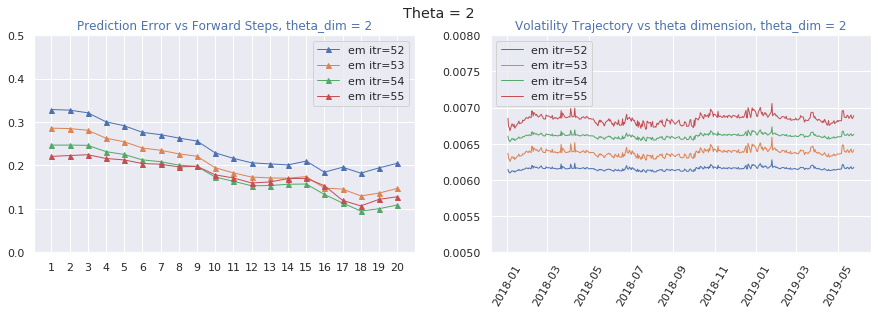

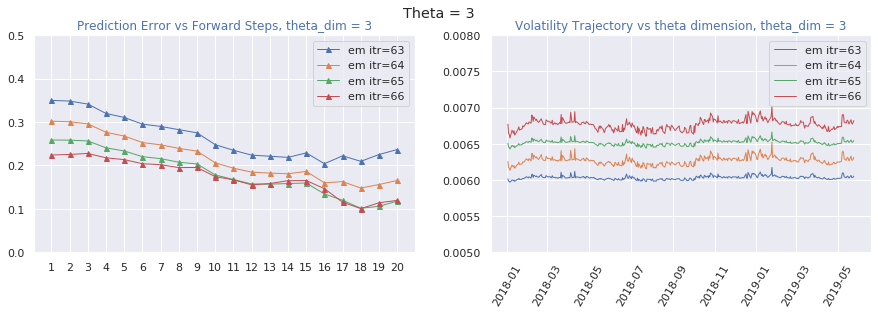

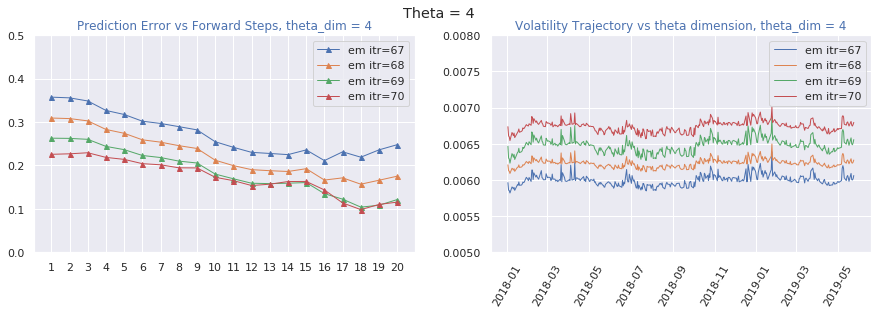

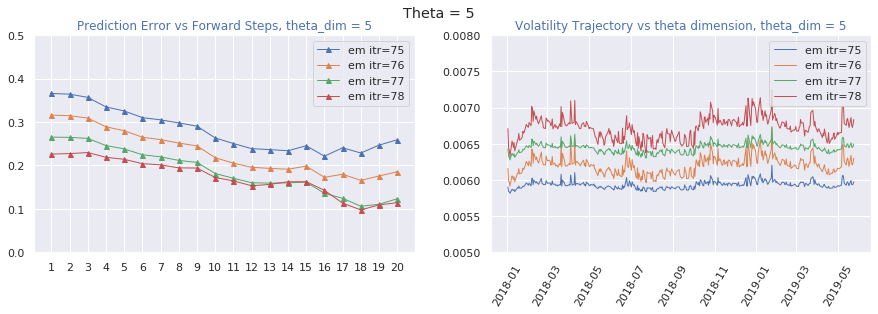

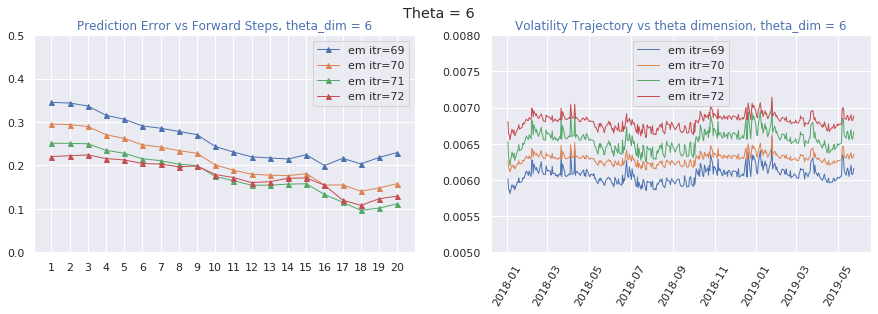

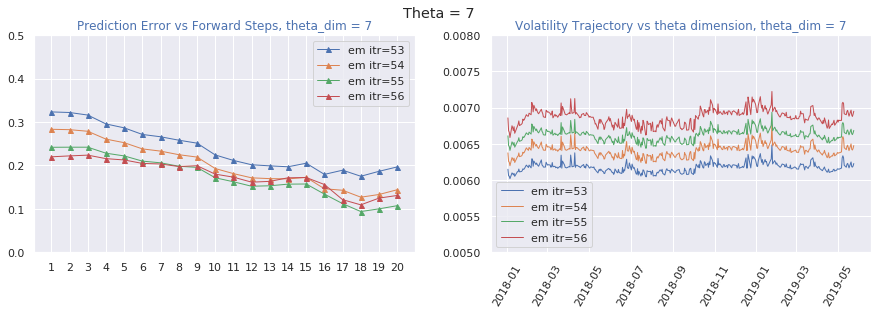

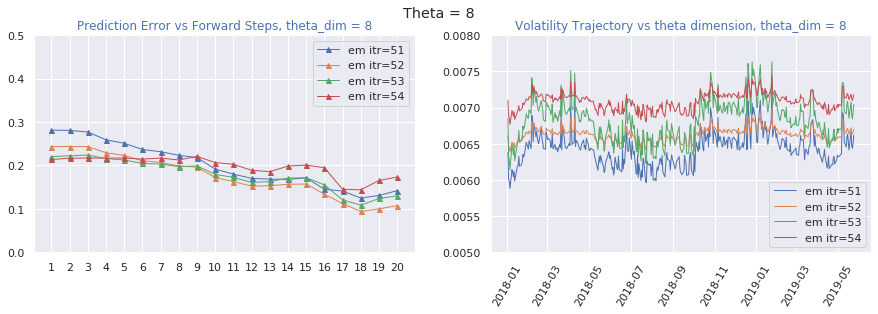

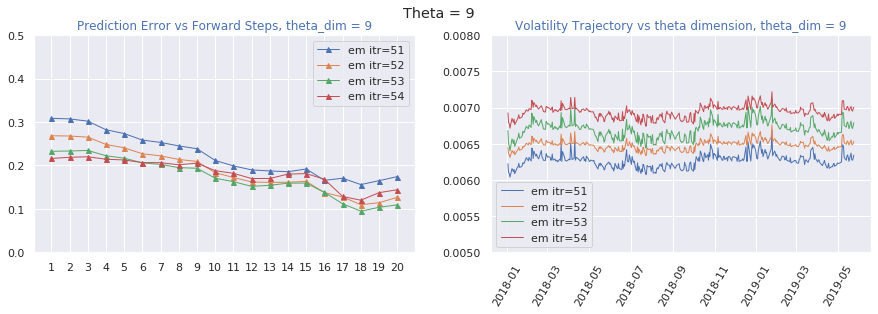

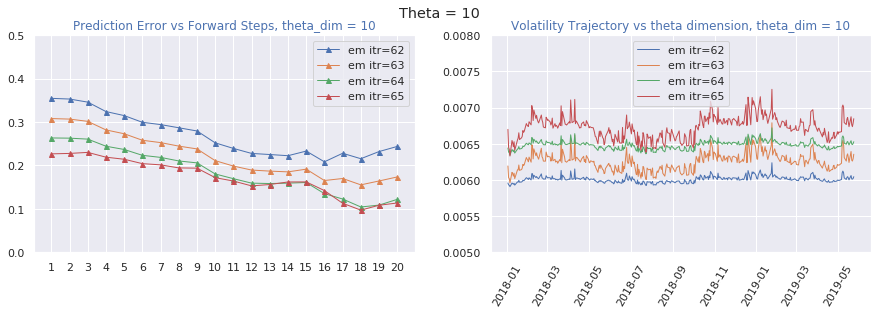

In [151]:
for k in range(len(error_for_all_theta_dim)):

    sns.set()
    fig = plt.figure(figsize=(15, 4))
    fig.suptitle("Theta = {}".format(k+2))
    
    iteratons = range(best_itr_for_all_theta_dim[k]-9, best_itr_for_all_theta_dim[k]-5)
    
    # forward steps
    a = fig.add_subplot(121)
    
    
    xlabel = list(range(len(k_step_test_error)+1))
    plt.xticks(xlabel)
    a.set_ylim(0.0, 0.5)
    a.set_title('Prediction Error vs Forward Steps, theta_dim = {}'.format(k+2), color='C0')
    for i in iteratons:
        show = error_for_all_theta_dim[k][i]
        a.plot([i+1 for i in range(len(k_step_test_error))], show, marker='^', markersize= 5, linewidth=1)
    a.legend(["em itr={}".format(i) for i in iteratons])
    
    b = fig.add_subplot(122)
    b.xaxis_date()
    # volatility trajectory
    b.set_title('Volatility Trajectory vs theta dimension, theta_dim = {}'.format(k+2), color='C0')
    b.set_ylim(0.005, 0.008)
    for i in iteratons:
        volatility_mean = np.average(ms_s_for_all_theta_dim[k][i], axis=1)
        b.plot(all_days, volatility_mean[1:], linewidth=1)
    b.legend(["em itr={}".format(i) for i in iteratons])
    plt.xticks(rotation=60)
    fig.show()





# Test Implied Volatility

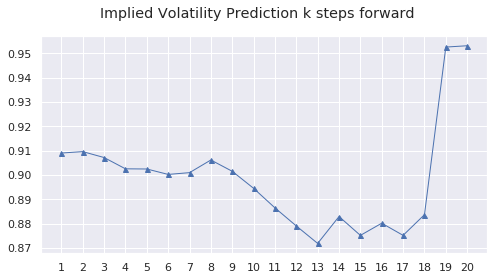

In [176]:
base_date = list(valid_data.keys())[-1]
base_date_vol = np.average(valid_data[list(valid_data.keys())[-1]][0]["impl_volatility"].values) / bday_p_year

test_days = list(test_data.keys())
test_error_traj_imp_vol = []
for k in range(1, min(forward_k+1, num_test_day+1)):
    k_step_test_error_imp_vol = []
    for idx in range(k-1, num_test_day):
        pred_date = test_days[idx]
        pred_date_p = test_data[pred_date][3]
        pred_date_r = test_data[pred_date][1] / bday_p_year
        pred_date_K = test_data[pred_date][0]["strike_price"].values
        today = [d.date() for d in test_data[pred_date][0]["date"]]
        expireday = [d.date() for d in test_data[pred_date][0]["exdate"]]
        pred_date_T = np.busday_count(today, expireday)
        pred_date_y = test_data[pred_date][0]["spotclose"].values

        pred_price_imp_vol = BSf(base_date_vol, 
                                 p_t=pred_date_p, 
                                 r_t=pred_date_r, 
                                 K_t=pred_date_K, 
                                 T_t=pred_date_T)
        pred_error_imp_vol = np.average(np.abs(pred_price_imp_vol-pred_date_y) / pred_date_y)
        k_step_test_error_imp_vol.append(pred_error_imp_vol)

        base_date = test_days[idx-k+1]
        base_date_vol = np.average(valid_data[list(valid_data.keys())[-1]][0]["impl_volatility"].values) / bday_p_year

    test_error_traj_imp_vol.append(np.average(k_step_test_error_imp_vol))

fig = plt.figure(figsize=(8,4))
fig.suptitle("Implied Volatility Prediction k steps forward")
plt.xticks(xlabel)
plt.plot([_+1 for _ in range(forward_k)], test_error_traj_imp_vol, marker ='^', markersize=5, linewidth=1)
fig.show()

In [162]:
train_data[np.datetime64('2019-01-02T00:00:00.000000000')]

[              date     exdate  strike_price  best_bid  best_offer  volume  \
 7824298 2019-01-02 2019-06-21        3050.0      3.40         3.7   30005   
 7824308 2019-01-02 2019-06-21        3300.0      0.75         1.0   30005   
 7823256 2019-01-02 2019-01-18        2570.0     14.50        15.3   22363   
 7823260 2019-01-02 2019-01-18        2590.0      9.20         9.8   19735   
 7825956 2019-01-02 2019-01-11        2525.0     23.40        24.0   19555   
 
          impl_volatility  spotclose  
 7824298         0.149985      3.550  
 7824308         0.163895      0.875  
 7823256         0.180783     14.900  
 7823260         0.174487      9.500  
 7825956         0.192232     23.700  ,
 0.0279388,
 array([ 8.64007027e-05, -1.53957145e-02, -1.57721063e-02, -2.05882284e-02,
        -2.71122542e-02,  4.95937426e-02,  8.56268080e-03, -1.24158255e-03,
         8.49248436e-03,  1.26849667e-03]),
 2510.030029]